# BTC Predictor

In [45]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [46]:
from fastai.structured import *
from fastai.column_data import *
np.set_printoptions(threshold=50, edgeitems=20)
from ta import *

## Stock Predictor Lib


In [47]:
def cleanData(df):
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.fillna(method='bfill')
#     df = df.dropna()
#     df = df.replace(np.nan,df.mean())
    return df

In [48]:
def calculateAccuracy(df):
    successfulPredictions = df.loc[df.action == df.predicted]
    # total accuracy does not provide an accurate represantation
    # totalAccuracy = len(successfulPredictions)/len(df)
    totalBuyActions = df.loc[df.action == 1]
    totalSellActions = df.loc[df.action == 0]
    successfulBuyPredictions = successfulPredictions.loc[successfulPredictions.action == 1]
    successfulSellPredictions = successfulPredictions.loc[successfulPredictions.action == 0]
    buyAccuracy = len(successfulBuyPredictions)/len(totalBuyActions)
    sellAccuracy = len(successfulSellPredictions)/len(totalSellActions)
    result = {
        'F1Score': (buyAccuracy + sellAccuracy )/2,
        'buyAccuracy': buyAccuracy,
        'sellAccuracy': sellAccuracy,
        'totalBuyActions': len(totalBuyActions),
        'successfulBuyPredictions': len(successfulBuyPredictions)
    }
    return result
            
def calculateNetProfit(dataFrame, startAmount):
    df = dataFrame
    df['buyAmount'] = 0
    df['sellAmount'] = 0
    totalBuys = 0
    totalSells = 0
    for index, row in df.iterrows():
        prevBuyAmount = df.buyAmount.get(index -1, np.nan)
        prevSellAmount = df.sellAmount.get(index -1, np.nan)
#         prevPredicted = df.predicted.get(index -1, np.nan)
        predicted = row.predicted
        if index == df.index[0]:
            df.loc[index,'buyAmount'] = startAmount
        elif predicted == 1 and prevBuyAmount > 0:
            # BUY
            df.loc[index,'sellAmount'] = prevBuyAmount/row.Close
            totalBuys +=1
        elif predicted == 1 and prevBuyAmount == 0:
            df.loc[index,'sellAmount'] = prevSellAmount
        elif predicted == 0 and prevSellAmount > 0:
            # SELL             
            df.loc[index,'buyAmount'] = prevSellAmount*row.Close
            totalSells +=1
        elif predicted == 0 and prevSellAmount == 0:
            df.loc[index,'buyAmount'] = prevBuyAmount
        else:
            # HOLD (not holding currently)
            df.loc[index,'buyAmount'] = prevBuyAmount
            df.loc[index,'sellAmount'] = prevSellAmount
        
            
    startClose = df.Close.iloc[0]
    endClose = df.Close.iloc[-1]
    endBuyAmount = df.buyAmount.iloc[-1]
    endSellAmount = df.sellAmount.iloc[-1]
    endAmount = endBuyAmount if (endBuyAmount > 0) else (endSellAmount * endClose)
    
    buyAndHoldPercentIncrease = ((endClose - startClose)/startClose) * 100
    percentIncrease = ((endAmount - startAmount)/startAmount) * 100
    percentDifference = percentIncrease - buyAndHoldPercentIncrease
    
    result = {
        'startClose': startClose,
        'endClose': endClose,
        'startAmount': startAmount,
        'endAmount': endAmount,
        'buyAndHoldPercentIncrease':round(buyAndHoldPercentIncrease,3),
        'percentIncrease':round(percentIncrease,3),
        'percentDifference':round(percentDifference,3),
        'totalBuys':totalBuys,
        'totalSells':totalSells
    }
    return df,result


In [49]:
#  use conflateTimeFrame(df, '5T')
def conflateTimeFrame(df, timeFrame):
    ohlc_dict = {                                                                                                             
        'Open':'first',                                                                                                    
        'High':'max',                                                                                                       
        'High':'max',                                                                                                       
        'Low':'min',                                                                                                        
        'Close': 'last',                                                                                                    
        'Volume': 'sum'
    }
    return df.resample(timeFrame).agg(ohlc_dict)

## Config


In [50]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

lookahead = 25
percentIncrease = 1.003
recordsCount = 60000
testRecordsCount = 10000
trainRecordsCount = 50000
trainRatio = 0.90
lr = 1e-4
dropout = 0.06
modelName = 'btcBinaryClassificationModel'
index='Timestamp'
dep = 'action'
PATH='data/stock/'

## Create datasets

In [51]:
table_names = ['btc-bitstamp-2012-01-01_to_2018-01-08']

In [52]:
tables = [pd.read_csv(f'{PATH}{fname}.csv', low_memory=False) for fname in table_names]

In [53]:
from IPython.display import HTML

In [54]:
for t in tables: display(t.head())

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
2,1325318040,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
3,1325318100,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
4,1325318160,4.39,4.39,4.39,4.39,0.455581,2.0,4.39


The following returns summarized aggregate information to each table accross each field.

In [55]:
# for t in tables: display(DataFrameSummary(t).summary())

In [56]:
train= tables[0]

In [57]:
len(train)

3161057

In [58]:
# trim to x records for now
# TODO: remove this
# train = train.tail(500000)
train = train.tail(recordsCount)
len(train)

60000

In [59]:
train.reset_index(inplace=True)
train.to_feather(f'{PATH}train')

## Data Cleaning

In [60]:
train = pd.read_feather(f'{PATH}train')

In [61]:
#convert to date objects
train[index] = pd.to_datetime(train[index], unit='s')
train.head()

,index,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,3101057,2017-11-27 08:01:00,9587.39,9587.39,9555.09,9565.04,9.899310,94727.690741,9569.120955
1,3101058,2017-11-27 08:02:00,9564.99,9576.69,9559.51,9571.63,11.203913,107152.209410,9563.820177
2,3101059,2017-11-27 08:03:00,9569.00,9585.62,9568.99,9584.87,19.761012,189385.644710,9583.803124
3,3101060,2017-11-27 08:04:00,9588.99,9594.69,9570.01,9589.98,4.749687,45524.841338,9584.809519
4,3101061,2017-11-27 08:05:00,9589.98,9597.94,9570.00,9580.01,16.868802,161553.581200,9577.063346


SET DEPENDENT VARIABLE ACTION

In [62]:
# edit columns
train["Volume"] = train["Volume_(BTC)"]
train.drop('Volume_(BTC)',1,inplace=True)
train["VolumeCurrency"] = train["Volume_(Currency)"]
train.drop('Volume_(Currency)',1,inplace=True)

# delete unused columns
train.drop('VolumeCurrency',1,inplace=True)
train.drop('Weighted_Price',1,inplace=True)

train.head()

,index,Timestamp,Open,High,Low,Close,Volume
0,3101057,2017-11-27 08:01:00,9587.39,9587.39,9555.09,9565.04,9.899310
1,3101058,2017-11-27 08:02:00,9564.99,9576.69,9559.51,9571.63,11.203913
2,3101059,2017-11-27 08:03:00,9569.00,9585.62,9568.99,9584.87,19.761012
3,3101060,2017-11-27 08:04:00,9588.99,9594.69,9570.01,9589.98,4.749687
4,3101061,2017-11-27 08:05:00,9589.98,9597.94,9570.00,9580.01,16.868802


In [63]:
# train = conflateTimeFrame(train, '5T')
# train[index] = train.index
# train.head()

In [64]:
len(train)

60000

## Feature Engineering

In [65]:
# add technical analysis
train = add_all_ta_features(train, "Open", "High", "Low", "Close", "Volume", fillna=True)
train = cleanData(train)
len(train)

60000

In [66]:
# train['action'] = 0;
# train.loc[train['Close'].rolling(window=lookahead).max() > train['Close'], 'action'] = 1
# train.loc[train['Close'].rolling(window=lookahead).max() > percentIncrease * train['Close'], 'action'] = 2
maxLookahead = train.Close.iloc[::-1] \
                            .rolling(window=lookahead,min_periods=1) \
                            .max() \
                            .iloc[::-1]
# maxLookahead = train.Close.rolling(window=lookahead,min_periods=1).max()
train['action'] =  maxLookahead > (percentIncrease * train['Close'])
train['max'] = maxLookahead
train.action = train.action.astype(int)

# target count by category
len(train[train.action==2]),len(train[train.action==1]),len(train[train.action==0])

(0, 34312, 25688)

Time modifications

In [67]:
# add all date time values
add_datepart(train, index, drop=False)
train['hour'] = train[index].dt.hour;
train['minute'] = train[index].dt.minute;
len(train)

60000

## Split validation and test sets

In [68]:
# # todo: make this into a percentage instead of hardcoding the test set 
# # todo: create function 
test = train.tail(testRecordsCount)
test.reset_index(inplace=True)
train = train.head(trainRecordsCount)
train.reset_index(inplace=True)
len(train),len(test)

(50000, 10000)

In [69]:
train.to_feather(f'{PATH}train')
test.to_feather(f'{PATH}test')

In [70]:
train.head(100)

,level_0,index,Timestamp,Open,High,Low,Close,Volume,volume_adi,volume_obv,volume_obvm,volume_cmf,volume_fi,volume_em,volume_vpt,volume_nvi,volatility_atr,volatility_bbh,volatility_bbl,volatility_bbm,volatility_bbhi,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kchi,volatility_kcli,volatility_dch,volatility_dcl,volatility_dchi,volatility_dcli,trend_macd,trend_macd_signal,trend_macd_diff,trend_ema_fast,trend_ema_slow,trend_adx,trend_adx_pos,trend_adx_neg,trend_adx_ind,trend_vortex_ind_pos,trend_vortex_ind_neg,trend_vortex_diff,trend_trix,trend_mass_index,trend_cci,trend_dpo,trend_kst,trend_kst_sig,trend_kst_diff,trend_ichimoku_a,trend_ichimoku_b,momentum_rsi,momentum_mfi,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,others_dr,others_cr,action,max,TimestampYear,TimestampMonth,TimestampWeek,TimestampDay,TimestampDayofweek,TimestampDayofyear,TimestampIs_month_end,TimestampIs_month_start,TimestampIs_quarter_end,TimestampIs_quarter_start,TimestampIs_year_end,TimestampIs_year_start,TimestampElapsed,hour,minute
0,0,3101057,2017-11-27 08:01:00,9587.39,9587.39,9555.09,9565.04,9.899310,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1000.000000,32.300000,9691.635981,9541.641019,9616.6385,0.0,0.0,9585.598333,9606.630333,9564.566333,0.0,0.0,9676.00,9565.04,0.0,0.0,0.000000,0.000000,0.000000,9565.040000,9565.040000,40.000000,20.000000,20.000000,0,1.000000,1.000000,0.000000,0.000000,25.000000,0.000000,0.0000,0.000000,0.000000,0.000000,9640.5550,9631.545,50.000000,50.000000,0.000000,50.000000,50.000000,50.000000,-50.000000,0.000000,0.000000,0.000000,0,9565.04,2017,11,48,27,0,331,False,False,False,False,False,False,1511769660,8,1
1,1,3101058,2017-11-27 08:02:00,9564.99,9576.69,9559.51,9571.63,11.203913,0.803815,11.203913,0.000000,0.000000,0.000000,0.000000,0.000000,1000.000000,24.479310,9691.635981,9541.641019,9616.6385,0.0,0.0,9585.598333,9606.630333,9564.566333,0.0,0.0,9676.00,9565.04,0.0,0.0,0.069630,0.036647,0.032983,9568.466800,9568.397170,40.000000,20.000000,20.000000,0,1.000000,1.000000,0.000000,0.000000,25.000000,0.000000,0.0000,0.000000,0.000000,0.000000,9640.5550,9631.545,100.000000,50.000000,100.000000,50.000000,50.000000,50.000000,-50.000000,0.000000,0.068897,0.068897,0,9571.63,2017,11,48,27,0,331,False,False,False,False,False,False,1511769720,8,2
2,2,3101059,2017-11-27 08:03:00,9569.00,9585.62,9568.99,9584.87,19.761012,22.582768,19.761012,0.000000,0.000000,195.557551,0.000000,0.035054,1000.000000,21.680428,9691.635981,9541.641019,9616.6385,0.0,0.0,9585.598333,9606.630333,9564.566333,0.0,0.0,9676.00,9565.04,0.0,0.0,0.280951,0.126796,0.154155,9574.377548,9574.096597,40.000000,20.000000,20.000000,0,1.000000,1.000000,0.000000,0.000000,25.000000,0.000000,0.0000,0.000000,0.000000,0.000000,9640.5550,9631.545,100.000000,50.000000,100.000000,50.000000,50.000000,50.000000,-50.000000,0.000000,0.138325,0.207317,0,9584.87,2017,11,48,27,0,331,False,False,False,False,False,False,1511769780,8,3
3,3,3101060,2017-11-27 08:04:00,9588.99,9594.69,9570.01,9589.98,4.749687,20.915399,4.749687,0.000000,0.000000,-118.435055,0.000000,0.029867,1000.533132,22.509616,9691.635981,9541.641019,9616.6385,0.0,0.0,9585.598333,9606.630333,9564.566333,0.0,0.0,9676.00,9565.04,0.0,0.0,0.463212,0.224620,0.238592,9578.758198,9578.294986,40.000000,20.000000,20.000000,0,1.000000,1.000000,0.000000,0.000000,25.000000,0.000000,0.0000,0.000000,0.000000,0.000000,9640.5550,9631.545,100.000000,50.000000,100.000000,50.000000,50.000000,50.000000,-50.000000,0.000000,0.053313,0.260741,0,9589.98,2017,11,48,27,0,331,False,False,False,False,False,False,1511769840,8,4
4,4,3101061,2017-11-27 08:05:00,9589.98,9597.94,9570.00,9580.01,16.868802,-1.844908,-16.868802,0.000000,0.000000,14.056141,0.000000,-0.015005,1000.533132,23.750473,9691.635981,9541.641019,9616.6385,0.0,0.0,9585.598333,9606.630333,9564.566333,0.0,0.0,9676.00,9565.04,0.0,0.0,0.385795,0.263978,0.121817,9579.050150,9578.664355,40.000000,20.000000,20.

## Create features

In [71]:
train = pd.read_feather(f'{PATH}train')
test = pd.read_feather(f'{PATH}test')

In [72]:
train.tail(50).T.head(100)

,49950,49951,49952,49953,49954,49955,49956,49957,49958,49959,49960,49961,49962,49963,49964,49965,49966,49967,49968,49969,49970,49971,49972,49973,49974,49975,49976,49977,49978,49979,49980,49981,49982,49983,49984,49985,49986,49987,49988,49989,49990,49991,49992,49993,49994,49995,49996,49997,49998,49999
level_0,49950,49951,49952,49953,49954,49955,49956,49957,49958,49959,49960,49961,49962,49963,49964,49965,49966,49967,49968,49969,49970,49971,49972,49973,49974,49975,49976,49977,49978,49979,49980,49981,49982,49983,49984,49985,49986,49987,49988,49989,49990,49991,49992,49993,49994,49995,49996,49997,49998,49999
index,3151007,3151008,3151009,3151010,3151011,3151012,3151013,3151014,3151015,3151016,3151017,3151018,3151019,3151020,3151021,3151022,3151023,3151024,3151025,3151026,3151027,3151028,3151029,3151030,3151031,3151032,3151033,3151034,3151035,3151036,3151037,3151038,3151039,3151040,3151041,3151042,3151043,3151044,3151045,3151046,3151047,3151048,3151049,3151050,3151051,3151052,3151053,3151054,3151055,3151056
Timestamp,2018-01-01 00:31:00,2018-01-01 00:32:00,2018-01-01 00:33:00,2018-01-01 00:34:00,2018-01-01 00:35:00,2018-01-01 00:36:00,2018-01-01 00:37:00,2018-01-01 00:38:00,2018-01-01 00:39:00,2018-01-01 00:40:00,2018-01-01 00:41:00,2018-01-01 00:42:00,2018-01-01 00:43:00,2018-01-01 00:44:00,2018-01-01 00:45:00,2018-01-01 00:46:00,2018-01-01 00:47:00,2018-01-01 00:48:00,2018-01-01 00:49:00,2018-01-01 00:50:00,2018-01-01 00:51:00,2018-01-01 00:52:00,2018-01-01 00:53:00,2018-01-01 00:54:00,2018-01-01 00:55:00,2018-01-01 00:56:00,2018-01-01 00:57:00,2018-01-01 00:58:00,2018-01-01 00:59:00,2018-01-01 01:00:00,2018-01-01 01:01:00,2018-01-01 01:02:00,2018-01-01 01:03:00,2018-01-01 01:04:00,2018-01-01 01:05:00,2018-01-01 01:06:00,2018-01-01 01:07:00,2018-01-01 01:08:00,2018-01-01 01:09:00,2018-01-01 01:10:00,2018-01-01 01:11:00,2018-01-01 01:12:00,2018-01-01 01:13:00,2018-01-01 01:14:00,2018-01-01 01:15:00,2018-01-01 01:16:00,2018-01-01 01:17:00,2018-01-01 01:18:00,2018-01-01 01:19:00,2018-01-01 01:20:00
Open,13699.9,13686.4,13721.4,13711.4,13665,13727.1,13712,13669.3,13669.3,13727.5,13671.5,13647.6,13633.2,13671,13664,13661.7,13680.8,13716,13720,13720,13662.4,13732.8,13704.5,13693.6,13668.5,13622,13601,13628.5,13633.6,13635.1,13636.1,13678.9,13656,13675.4,13676.1,13679.5,13660,13600,13608,13587,13567,13614,13600,13600,13600,13567.8,13597,13643.9,13642.9,13675.2
High,13699.9,13721.4,13754.1,13727.9,13727.7,13727.1,13728.2,13710.9,13707.8,13731.5,13672.4,13671.7,13671,13671,13682.8,13680.8,13707.8,13720,13720,13742.3,13733.9,13733.1,13704.5,13693.6,13668.5,13630,13630,13651.9,13668.5,13681.4,13678.9,13680,13675.6,13676.1,13680,13679.7,13679.6,13610.2,13609.8,13595.4,13614,13614.1,13600,13600,13600,13599,13647,13643.9,13675.3,13694.1
Low,13672.6,13669.9,13711.4,13655.4,13665,13727,13668.4,13669.3,13669.3,13632.2,13646.6,13632.1,13632,13632,13632,13661.7,13655.7,13700,13700,13653.2,13662.4,13669.6,13668.5,13690.8,13622,13600.3,13601,13601,13633.6,13635.1,13636.1,13656,13656,13657,13660,13660,13600,13598,13564,13564,13564.1,13585.3,13565.7,13600,13565.2,13564.1,13576.3,13604.7,13605,13647.5
Close,13699,13721.4,13711.4,13665,13727.6,13727,13701.5,13707.8,13707.8,13706,13671.7,13633.2,13632,13664,13661.7,13680.8,13707.8,13720,13720,13655.5,13710,13669.6,13704.5,13690.8,13622,13630,13623.4,13651.8,13668.5,13681.4,13678.9,13656,13674.7,13676.1,13666.7,13660,13600,13610.2,13574,13567,13614,13614.1,13600,13600,13599,13597,13645,13618.5,13647.5,13694.1
Volume,1.19917,20.2918,0.505361,4.96789,0.110723,0.162831,11.702,3.17072,0.312759,5.12813,0.611623,4.33532,0.871489,1.78837,2.4758,0.116015,0.775738,6.85135,0.574298,3.66799,1.15904,1.27812,0.109093,0.0459614,13.2409,1.02044,0.19926,2.3952,1.49931,0.531898,9.46679,1.30616,1.14318,0.179416,0.860276,1.26541,8.65339,3.09669,15.4342,4.19633,1.03008,1.24946,0.272052,0.0454431,0.384441,0.885178,4.08005,0.283713,12.4654,18.4473
volume_adi,2.13399,21.4049,19.7788,-4.16131,-3.5455,-0.0521436,1.12261,3.9875,3.0148

In [73]:
# display(DataFrameSummary(train).summary())
# break break break now

Now that we've engineered all our features, we need to convert to input compatible with a neural network.

This includes converting categorical variables into contiguous integers or one-hot encodings, normalizing continuous features to standard normal, etc...

In [74]:
train.head()

,level_0,index,Timestamp,Open,High,Low,Close,Volume,volume_adi,volume_obv,volume_obvm,volume_cmf,volume_fi,volume_em,volume_vpt,volume_nvi,volatility_atr,volatility_bbh,volatility_bbl,volatility_bbm,volatility_bbhi,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kchi,volatility_kcli,volatility_dch,volatility_dcl,volatility_dchi,volatility_dcli,trend_macd,trend_macd_signal,trend_macd_diff,trend_ema_fast,trend_ema_slow,trend_adx,trend_adx_pos,trend_adx_neg,trend_adx_ind,trend_vortex_ind_pos,trend_vortex_ind_neg,trend_vortex_diff,trend_trix,trend_mass_index,trend_cci,trend_dpo,trend_kst,trend_kst_sig,trend_kst_diff,trend_ichimoku_a,trend_ichimoku_b,momentum_rsi,momentum_mfi,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,others_dr,others_cr,action,max,TimestampYear,TimestampMonth,TimestampWeek,TimestampDay,TimestampDayofweek,TimestampDayofyear,TimestampIs_month_end,TimestampIs_month_start,TimestampIs_quarter_end,TimestampIs_quarter_start,TimestampIs_year_end,TimestampIs_year_start,TimestampElapsed,hour,minute
0,0,3101057,2017-11-27 08:01:00,9587.39,9587.39,9555.09,9565.04,9.899310,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,1000.000000,32.300000,9691.635981,9541.641019,9616.6385,0.0,0.0,9585.598333,9606.630333,9564.566333,0.0,0.0,9676.0,9565.04,0.0,0.0,0.000000,0.000000,0.000000,9565.040000,9565.040000,40.0,20.0,20.0,0,1.0,1.0,0.0,0.0,25.0,0.0,0.0,0.0,0.0,0.0,9640.555,9631.545,50.000000,50.0,0.000000,50.0,50.0,50.0,-50.0,0.0,0.000000,0.000000,0,9565.04,2017,11,48,27,0,331,False,False,False,False,False,False,1511769660,8,1
1,1,3101058,2017-11-27 08:02:00,9564.99,9576.69,9559.51,9571.63,11.203913,0.803815,11.203913,0.0,0.0,0.000000,0.0,0.000000,1000.000000,24.479310,9691.635981,9541.641019,9616.6385,0.0,0.0,9585.598333,9606.630333,9564.566333,0.0,0.0,9676.0,9565.04,0.0,0.0,0.069630,0.036647,0.032983,9568.466800,9568.397170,40.0,20.0,20.0,0,1.0,1.0,0.0,0.0,25.0,0.0,0.0,0.0,0.0,0.0,9640.555,9631.545,100.000000,50.0,100.000000,50.0,50.0,50.0,-50.0,0.0,0.068897,0.068897,0,9571.63,2017,11,48,27,0,331,False,False,False,False,False,False,1511769720,8,2
2,2,3101059,2017-11-27 08:03:00,9569.00,9585.62,9568.99,9584.87,19.761012,22.582768,19.761012,0.0,0.0,195.557551,0.0,0.035054,1000.000000,21.680428,9691.635981,9541.641019,9616.6385,0.0,0.0,9585.598333,9606.630333,9564.566333,0.0,0.0,9676.0,9565.04,0.0,0.0,0.280951,0.126796,0.154155,9574.377548,9574.096597,40.0,20.0,20.0,0,1.0,1.0,0.0,0.0,25.0,0.0,0.0,0.0,0.0,0.0,9640.555,9631.545,100.000000,50.0,100.000000,50.0,50.0,50.0,-50.0,0.0,0.138325,0.207317,0,9584.87,2017,11,48,27,0,331,False,False,False,False,False,False,1511769780,8,3
3,3,3101060,2017-11-27 08:04:00,9588.99,9594.69,9570.01,9589.98,4.749687,20.915399,4.749687,0.0,0.0,-118.435055,0.0,0.029867,1000.533132,22.509616,9691.635981,9541.641019,9616.6385,0.0,0.0,9585.598333,9606.630333,9564.566333,0.0,0.0,9676.0,9565.04,0.0,0.0,0.463212,0.224620,0.238592,9578.758198,9578.294986,40.0,20.0,20.0,0,1.0,1.0,0.0,0.0,25.0,0.0,0.0,0.0,0.0,0.0,9640.555,9631.545,100.000000,50.0,100.000000,50.0,50.0,50.0,-50.0,0.0,0.053313,0.260741,0,9589.98,2017,11,48,27,0,331,False,False,False,False,False,False,1511769840,8,4
4,4,3101061,2017-11-27 08:05:00,9589.98,9597.94,9570.00,9580.01,16.868802,-1.844908,-16.868802,0.0,0.0,14.056141,0.0,-0.015005,1000.533132,23.750473,9691.635981,9541.641019,9616.6385,0.0,0.0,9585.598333,9606.630333,9564.566333,0.0,0.0,9676.0,9565.04,0.0,0.0,0.385795,0.263978,0.121817,9579.050150,9578.664355,40.0,20.0,20.0,0,1.0,1.0,0.0,0.0,25.0,0.0,0.0,0.0,0.0,0.0,9640.555,9631.545,68.480048,50.0,82.578672,50.0,50.0,50.0,-50.0,0.0,-0.103963,0.156507,0,9589.98,2017,11,48,27,0,331,False,False,False,False,False,False,1511769900,8,5


Identify categorical vs continuous variables

In [75]:
cat_vars = ['TimestampYear', 'TimestampMonth', 'TimestampWeek', 'TimestampDay', 'hour','minute', 'TimestampDayofweek',
'TimestampDayofyear','TimestampIs_month_end', 'TimestampIs_month_start', 'TimestampIs_quarter_end',
'TimestampIs_quarter_start','TimestampIs_year_end', 'TimestampIs_year_start']

# techincal_indicators = ['volume_adi','volume_obv','volume_obvm','volume_cmf','volume_nvi','volatility_bbh',
# 'volatility_bbl','volatility_atr','volatility_bbm','trend_mass_index','trend_macd','trend_macd_signal',
# 'trend_kst','trend_kst_sig','trend_kst_diff','trend_macd_diff','trend_ema_fast','trend_ema_slow','trend_adx',
# 'trend_adx_pos','trend_adx_neg','trend_adx_ind','trend_ichimoku_a','trend_ichimoku_b','momentum_rsi','momentum_mfi',
# 'momentum_tsi','momentum_uo','momentum_stoch','momentum_stoch_signal','momentum_wr','momentum_ao']

contin_vars = ['Open', 'Close','High', 'Low', 'Volume', 'TimestampElapsed',
'volume_adi','volume_obv','volume_obvm','volume_cmf','volume_fi','volume_em','volume_vpt','volume_nvi',
'volatility_atr','volatility_bbh','volatility_bbl','volatility_bbm','volatility_bbhi','volatility_bbli',
'volatility_kcc','volatility_kch','volatility_kcl','volatility_kchi','volatility_kcli','volatility_dch',
'volatility_dcl','volatility_dchi','volatility_dcli','trend_macd','trend_macd_signal','trend_macd_diff',
'trend_ema_fast','trend_ema_slow','trend_adx','trend_adx_pos','trend_adx_neg','trend_adx_ind','trend_vortex_ind_pos',
'trend_vortex_ind_neg','trend_vortex_diff','trend_trix','trend_mass_index','trend_cci','trend_dpo','trend_kst',
'trend_kst_sig','trend_kst_diff','trend_ichimoku_a','trend_ichimoku_b','momentum_rsi','momentum_mfi','momentum_tsi',
'momentum_uo','momentum_stoch','momentum_stoch_signal','momentum_wr','momentum_ao']
# 'others_dr','others_cr'

# contin_vars = [base_vars+techincal_indicators]

n = len(train); n

test = test.set_index(index)
train = train.set_index(index)

len(contin_vars)

58

In [76]:
train = train[cat_vars+contin_vars+[dep]].copy()
# , index

In [77]:
# test[dep] = 0 
test = test[cat_vars+contin_vars+[dep]].copy()
# , index


In [78]:
for v in cat_vars: train[v] = train[v].astype('category').cat.as_ordered()
#     todo: maybe change dep variable to category here for multiclass option

In [79]:
apply_cats(test, train)
# test

In [80]:
for v in contin_vars:
    train[v] = train[v].astype('float32')
    test[v] = test[v].astype('float32')

We can now process our data...

In [81]:
df, y, nas, mapper = proc_df(train, dep, do_scale=True)

In [82]:
y.shape

(50000,)

In [83]:
df_test, _, nas, mapper = proc_df(test, dep, do_scale=True, mapper=mapper, na_dict=nas)
train.head(30).T.head(70)

Timestamp,2017-11-27 08:01:00,2017-11-27 08:02:00,2017-11-27 08:03:00,2017-11-27 08:04:00,2017-11-27 08:05:00,2017-11-27 08:06:00,2017-11-27 08:07:00,2017-11-27 08:08:00,2017-11-27 08:09:00,2017-11-27 08:10:00,2017-11-27 08:11:00,2017-11-27 08:12:00,2017-11-27 08:13:00,2017-11-27 08:14:00,2017-11-27 08:15:00,2017-11-27 08:16:00,2017-11-27 08:17:00,2017-11-27 08:18:00,2017-11-27 08:19:00,2017-11-27 08:20:00,2017-11-27 08:21:00,2017-11-27 08:22:00,2017-11-27 08:23:00,2017-11-27 08:24:00,2017-11-27 08:25:00,2017-11-27 08:26:00,2017-11-27 08:27:00,2017-11-27 08:28:00,2017-11-27 08:29:00,2017-11-27 08:30:00
TimestampYear,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017
TimestampMonth,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11
TimestampWeek,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48
TimestampDay,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27
hour,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8
minute,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30
TimestampDayofweek,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
TimestampDayofyear,331,331,331,331,331,331,331,331,331,331,331,331,331,331,331,331,331,331,331,331,331,331,331,331,331,331,331,331,331,331
TimestampIs_month_end,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
TimestampIs_month_start,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [84]:
nas={}

In [85]:
df.head(2)

,TimestampYear,TimestampMonth,TimestampWeek,TimestampDay,hour,minute,TimestampDayofweek,TimestampDayofyear,TimestampIs_month_end,TimestampIs_month_start,TimestampIs_quarter_end,TimestampIs_quarter_start,TimestampIs_year_end,TimestampIs_year_start,Open,Close,High,Low,Volume,TimestampElapsed,volume_adi,volume_obv,volume_obvm,volume_cmf,volume_fi,volume_em,volume_vpt,volume_nvi,volatility_atr,volatility_bbh,volatility_bbl,volatility_bbm,volatility_bbhi,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kchi,volatility_kcli,volatility_dch,volatility_dcl,volatility_dchi,volatility_dcli,trend_macd,trend_macd_signal,trend_macd_diff,trend_ema_fast,trend_ema_slow,trend_adx,trend_adx_pos,trend_adx_neg,trend_adx_ind,trend_vortex_ind_pos,trend_vortex_ind_neg,trend_vortex_diff,trend_trix,trend_mass_index,trend_cci,trend_dpo,trend_kst,trend_kst_sig,trend_kst_diff,trend_ichimoku_a,trend_ichimoku_b,momentum_rsi,momentum_mfi,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao
Timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-11-27 08:01:00,1,2,2,27,9,2,1,2,1,1,1,1,1,1,-1.755223,-1.763375,-1.761124,-1.760095,-0.152114,-1.732088,-0.088989,-0.002862,-0.00693,-0.436338,0.049849,0.047505,0.027761,-1.064163,-0.670403,-1.748608,-1.737749,-1.744026,-0.226747,-0.243561,-1.755347,-1.760434,-1.75007,-0.014144,-0.018442,-1.747669,-1.73326,-0.446333,-0.354821,-0.020505,-0.022038,0.000330,-1.763372,-1.763256,-0.084833,0.229125,-0.012156,-0.858145,0.012491,0.23044,-1.177795,-0.017388,0.058883,-0.06117,-0.005041,-0.02294,-0.023466,-0.000002,-1.730872,-1.731254,-0.122777,-0.072037,-0.148397,-0.481613,-0.231841,-0.250683,-0.231842,-0.011165
2017-11-27 08:02:00,1,2,2,27,9,3,1,2,1,1,1,1,1,1,-1.763521,-1.760934,-1.765084,-1.758456,-0.084890,-1.731940,-0.061705,0.483745,-0.00693,-0.436338,0.049849,0.047505,0.027761,-1.064163,-0.995208,-1.748608,-1.737749,-1.744026,-0.226747,-0.243561,-1.755347,-1.760434,-1.75007,-0.014144,-0.018442,-1.747669,-1.73326,-0.446333,-0.354821,-0.019251,-0.021332,0.002103,-1.762103,-1.762011,-0.084833,0.229125,-0.012156,-0.858145,0.012491,0.23044,-1.177795,-0.017388,0.058883,-0.06117,-0.005041,-0.02294,-0.023466,-0.000002,-1.730872,-1.731254,4.077992,-0.072037,6.815233,-0.481613,-0.231841,-0.250683,-0.231842,-0.011165


In [86]:
df_test.head(2)

,TimestampYear,TimestampMonth,TimestampWeek,TimestampDay,hour,minute,TimestampDayofweek,TimestampDayofyear,TimestampIs_month_end,TimestampIs_month_start,TimestampIs_quarter_end,TimestampIs_quarter_start,TimestampIs_year_end,TimestampIs_year_start,Open,Close,High,Low,Volume,TimestampElapsed,volume_adi,volume_obv,volume_obvm,volume_cmf,volume_fi,volume_em,volume_vpt,volume_nvi,volatility_atr,volatility_bbh,volatility_bbl,volatility_bbm,volatility_bbhi,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kchi,volatility_kcli,volatility_dch,volatility_dcl,volatility_dchi,volatility_dcli,trend_macd,trend_macd_signal,trend_macd_diff,trend_ema_fast,trend_ema_slow,trend_adx,trend_adx_pos,trend_adx_neg,trend_adx_ind,trend_vortex_ind_pos,trend_vortex_ind_neg,trend_vortex_diff,trend_trix,trend_mass_index,trend_cci,trend_dpo,trend_kst,trend_kst_sig,trend_kst_diff,trend_ichimoku_a,trend_ichimoku_b,momentum_rsi,momentum_mfi,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao
Timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-01 01:21:00,2,1,1,1,2,22,1,1,1,2,1,2,1,2,-0.233802,-0.233725,-0.241318,-0.224354,-0.652807,1.732088,0.543371,0.005065,0.362162,-0.078294,-0.168063,-0.277329,0.286109,2.830909,-0.411332,-0.267296,-0.246483,-0.257053,-0.226747,-0.243561,-0.259423,-0.262971,-0.255833,-0.014144,-0.018442,-0.264389,-0.245779,2.240479,-0.354821,-0.463438,-0.637046,0.395338,-0.252710,-0.243220,-0.405858,0.464569,-0.204544,1.165304,0.832178,-0.094715,-0.264529,-0.365805,-0.304544,1.242946,-0.568078,-0.341487,-0.487258,0.423037,-0.232757,-0.214908,0.60047,0.637292,-0.715468,1.106668,1.287537,1.087090,1.287537,0.030486
2018-01-01 01:22:00,2,1,1,1,2,23,1,1,1,2,1,2,1,2,-0.233791,-0.230335,-0.237502,-0.236257,-0.641499,1.732088,-0.069897,0.014596,0.353121,-0.008696,-0.013095,-0.664397,0.028864,2.830909,-0.400584,-0.264239,-0.247808,-0.256178,-0.226747,-0.243561,-0.256258,-0.259310,-0.253168,-0.014144,-0.018442,-0.261012,-0.245779,2.240479,-0.354821,-0.403041,-0.616437,0.518018,-0.250965,-0.242717,-0.587174,0.355728,0.188224,-0.858145,0.490569,-0.891503,0.079251,-0.285002,-0.235657,1.083616,-0.646312,-0.264653,-0.464539,0.594407,-0.236790,-0.219063,0.70753,0.565843,-0.642765,1.164067,1.262426,1.383298,1.262425,0.176898


Rake the last x% of rows as our validation set.

In [87]:
train_size = int(n * trainRatio); train_size
val_idx = list(range(train_size, len(df)))
#val_idx = list(range(0, len(df)-train_size))
#val_idx = get_cv_idxs(n, val_pct=0.1)

In [88]:
len(val_idx)

5000

## DL

We're ready to put together our models.

We can create a ModelData object directly from our data frame. Is_Reg is set to False to turn this into a classification problem (from a regression).  Is_multi is set True because there there are three labels for target BUY,HOLD,SELL

In [89]:
md = ColumnarModelData.from_data_frame(PATH, val_idx, df, y.astype('int'), cat_flds=cat_vars, bs=64,
                                      is_reg=False,is_multi=False,test_df=df_test)

Some categorical variables have a lot more levels than others.

In [90]:
cat_sz = [(c, len(train[c].cat.categories)+1) for c in cat_vars]

In [91]:
cat_sz

[('TimestampYear', 3),
 ('TimestampMonth', 4),
 ('TimestampWeek', 7),
 ('TimestampDay', 32),
 ('hour', 25),
 ('minute', 61),
 ('TimestampDayofweek', 8),
 ('TimestampDayofyear', 37),
 ('TimestampIs_month_end', 3),
 ('TimestampIs_month_start', 3),
 ('TimestampIs_quarter_end', 3),
 ('TimestampIs_quarter_start', 3),
 ('TimestampIs_year_end', 3),
 ('TimestampIs_year_start', 3)]

We use the *cardinality* of each variable (that is, its number of unique values) to decide how large to make its *embeddings*. Each level will be associated with a vector with length defined as below.

In [92]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]

In [93]:
emb_szs

[(3, 2),
 (4, 2),
 (7, 4),
 (32, 16),
 (25, 13),
 (61, 31),
 (8, 4),
 (37, 19),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2)]

Check if cuda is available

In [94]:
torch.cuda.is_available()

True

In [95]:
len(df.columns)-len(cat_vars)

58

In [96]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),dropout, 2, [100,50], [0.03,0.06],None,True)

In [97]:
m

MixedInputModel(
  (embs): ModuleList(
    (0): Embedding(3, 2)
    (1): Embedding(4, 2)
    (2): Embedding(7, 4)
    (3): Embedding(32, 16)
    (4): Embedding(25, 13)
    (5): Embedding(61, 31)
    (6): Embedding(8, 4)
    (7): Embedding(37, 19)
    (8): Embedding(3, 2)
    (9): Embedding(3, 2)
    (10): Embedding(3, 2)
    (11): Embedding(3, 2)
    (12): Embedding(3, 2)
    (13): Embedding(3, 2)
  )
  (lins): ModuleList(
    (0): Linear(in_features=161, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=50, bias=True)
  )
  (bns): ModuleList(
    (0): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True)
    (1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True)
  )
  (outp): Linear(in_features=50, out_features=2, bias=True)
  (emb_drop): Dropout(p=0.06)
  (drops): ModuleList(
    (0): Dropout(p=0.03)
    (1): Dropout(p=0.06)
  )
  (bn): BatchNorm1d(58, eps=1e-05, momentum=0.1, affine=True)
)

 68%|██████▊   | 479/704 [00:04<00:02, 105.32it/s, loss=0.334]


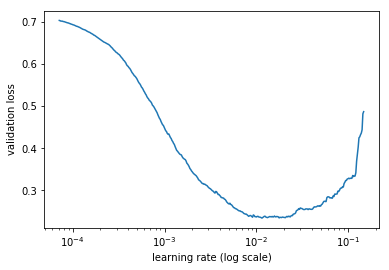

In [98]:
m.lr_find()
m.sched.plot(100)

In [99]:
m.fit(lr, 3)

epoch      trn_loss   val_loss                                
    0      0.265994   0.275852  
    1      0.217117   0.233958                                
    2      0.210869   0.213126                                



[array([0.21313])]

In [100]:
m.fit(lr, 5, cycle_len=1)

epoch      trn_loss   val_loss                                
    0      0.189276   0.209563  
    1      0.195074   0.206074                                
    2      0.177272   0.201616                                
    3      0.180515   0.19901                                 
    4      0.168033   0.196142                                



[array([0.19614])]

In [101]:
m.fit(lr, 3, cycle_len=4, cycle_mult=2 )

epoch      trn_loss   val_loss                                
    0      0.16794    0.193695  
    1      0.168384   0.189914                                
    2      0.162714   0.18926                                 
    3      0.158892   0.189113                                
    4      0.159439   0.186879                                
    5      0.157353   0.184051                                
    6      0.147356   0.184046                                
    7      0.156597   0.179718                                
    8      0.152335   0.180328                                
    9      0.153886   0.179544                                
    10     0.146288   0.179309                                
    11     0.144637   0.179291                                
    12     0.150414   0.177603                                
    13     0.149856   0.176533                                
    14     0.150215   0.176311                                
    15     0.142562   

[array([0.17233])]

In [102]:
m.save(modelName)

In [103]:
m.load(modelName)

## Validation

In [104]:
(x,y1)=m.predict_with_targs()

Predicted vs Validation

In [105]:
(np.argmax(x,axis=1),y1)

(array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..., 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 0]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..., 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 0, 0]))

In [106]:
y1.shape

(5000,)

In [107]:
val = train.iloc[val_idx]
val[[dep]]
valpred = pd.DataFrame({'Close':val.Close,'index':val.index, 'action':val.action, 'predicted':np.argmax(x,axis=1)})[['Close','index', 'action','predicted']]
valpred.tail(100)

,Close,index,action,predicted
Timestamp,,,,
2017-12-31 23:41:00,13989.799805,2017-12-31 23:41:00,0,0
2017-12-31 23:42:00,13959.870117,2017-12-31 23:42:00,0,1
2017-12-31 23:43:00,13930.000000,2017-12-31 23:43:00,1,1
2017-12-31 23:44:00,13890.950195,2017-12-31 23:44:00,1,1
2017-12-31 23:45:00,13929.959961,2017-12-31 23:45:00,1,1
2017-12-31 23:46:00,13889.009766,2017-12-31 23:46:00,1,1
2017-12-31 23:47:00,13941.610352,2017-12-31 23:47:00,1,1
2017-12-31 23:48:00,13942.349609,2017-12-31 23:48:00,1,1
2017-12-31 23:49:00,13927.339844,2017-12-31 23:49:00,1,1


Calculate the percent accuracy on the validation set

In [108]:
calculateAccuracy(valpred)

{'F1Score': 0.9034944390703549,
 'buyAccuracy': 0.952755905511811,
 'sellAccuracy': 0.8542329726288987,
 'totalBuyActions': 3429,
 'successfulBuyPredictions': 3267}

In [109]:
newdf,result = calculateNetProfit(valpred, 10000)
result

{'startClose': 14243.75,
 'endClose': 13694.09,
 'startAmount': 10000,
 'endAmount': 11580.028126561092,
 'buyAndHoldPercentIncrease': -3.859,
 'percentIncrease': 15.8,
 'percentDifference': 19.659,
 'totalBuys': 310,
 'totalSells': 310}

In [110]:
newdf.head(10)

,Close,index,action,predicted,buyAmount,sellAmount
Timestamp,,,,,,
2017-12-28 14:01:00,14243.750000,2017-12-28 14:01:00,1,1,10000.0,0.000000
2017-12-28 14:02:00,14220.280273,2017-12-28 14:02:00,1,1,0.0,0.703221
2017-12-28 14:03:00,14099.000000,2017-12-28 14:03:00,1,1,0.0,0.703221
2017-12-28 14:04:00,14090.000000,2017-12-28 14:04:00,1,1,0.0,0.703221
2017-12-28 14:05:00,14092.870117,2017-12-28 14:05:00,1,1,0.0,0.703221
2017-12-28 14:06:00,14042.030273,2017-12-28 14:06:00,1,1,0.0,0.703221
2017-12-28 14:07:00,14050.940430,2017-12-28 14:07:00,1,1,0.0,0.703221
2017-12-28 14:08:00,14025.599609,2017-12-28 14:08:00,1,1,0.0,0.703221
2017-12-28 14:09:00,13950.099609,2017-12-28 14:09:00,1,1,0.0,0.703221


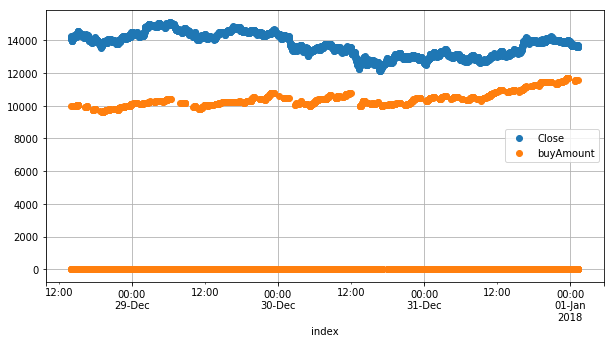

In [111]:
newdf.plot(x='index', y=['Close', 'buyAmount'], style='o',figsize=(10,5), grid=True)

In [112]:
newdf.tail(10)

,Close,index,action,predicted,buyAmount,sellAmount
Timestamp,,,,,,
2018-01-01 01:11:00,13614.030273,2018-01-01 01:11:00,1,1,0.000000,0.845622
2018-01-01 01:12:00,13614.059570,2018-01-01 01:12:00,1,1,0.000000,0.845622
2018-01-01 01:13:00,13600.000000,2018-01-01 01:13:00,1,1,0.000000,0.845622
2018-01-01 01:14:00,13600.000000,2018-01-01 01:14:00,1,1,0.000000,0.845622
2018-01-01 01:15:00,13599.000000,2018-01-01 01:15:00,1,1,0.000000,0.845622
2018-01-01 01:16:00,13597.000000,2018-01-01 01:16:00,1,1,0.000000,0.845622
2018-01-01 01:17:00,13644.959961,2018-01-01 01:17:00,1,1,0.000000,0.845622
2018-01-01 01:18:00,13618.469727,2018-01-01 01:18:00,1,1,0.000000,0.845622
2018-01-01 01:19:00,13647.469727,2018-01-01 01:19:00,0,1,0.000000,0.845622


## Test

In [113]:
np.argmax(m.predict(True), axis =1)

array([0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..., 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1])

In [114]:
testPred = pd.DataFrame({'Timestamp':test.index, 'Close':test.Close, 'action':test.action, 'predicted':np.argmax(m.predict(True), axis =1)})[['Close','Timestamp', 'action', 'predicted']]
testPred.head(10)

,Close,Timestamp,action,predicted
Timestamp,,,,
2018-01-01 01:21:00,13694.110352,2018-01-01 01:21:00,0,0
2018-01-01 01:22:00,13703.259766,2018-01-01 01:22:00,0,0
2018-01-01 01:23:00,13690.679688,2018-01-01 01:23:00,0,0
2018-01-01 01:24:00,13651.230469,2018-01-01 01:24:00,1,1
2018-01-01 01:25:00,13651.250000,2018-01-01 01:25:00,1,1
2018-01-01 01:26:00,13651.250000,2018-01-01 01:26:00,1,1
2018-01-01 01:27:00,13651.219727,2018-01-01 01:27:00,1,1
2018-01-01 01:28:00,13650.990234,2018-01-01 01:28:00,1,1
2018-01-01 01:29:00,13651.000000,2018-01-01 01:29:00,1,1


Calculate the percent accuracy on the test set

In [115]:
calculateAccuracy(testPred)

{'F1Score': 0.8848635292857558,
 'buyAccuracy': 0.9698668535388928,
 'sellAccuracy': 0.7998602050326188,
 'totalBuyActions': 5708,
 'successfulBuyPredictions': 5536}

In [116]:
newdf,result = calculateNetProfit(testPred, 10000)
result

{'startClose': 13694.11,
 'endClose': 16166.78,
 'startAmount': 10000,
 'endAmount': 19955.22266533948,
 'buyAndHoldPercentIncrease': 18.056,
 'percentIncrease': 99.552,
 'percentDifference': 81.496,
 'totalBuys': 657,
 'totalSells': 656}

In [117]:
newdf.head(10)

,Close,Timestamp,action,predicted,buyAmount,sellAmount
Timestamp,,,,,,
2018-01-01 01:21:00,13694.110352,2018-01-01 01:21:00,0,0,10000.0,0.000000
2018-01-01 01:22:00,13703.259766,2018-01-01 01:22:00,0,0,10000.0,0.000000
2018-01-01 01:23:00,13690.679688,2018-01-01 01:23:00,0,0,10000.0,0.000000
2018-01-01 01:24:00,13651.230469,2018-01-01 01:24:00,1,1,0.0,0.732535
2018-01-01 01:25:00,13651.250000,2018-01-01 01:25:00,1,1,0.0,0.732535
2018-01-01 01:26:00,13651.250000,2018-01-01 01:26:00,1,1,0.0,0.732535
2018-01-01 01:27:00,13651.219727,2018-01-01 01:27:00,1,1,0.0,0.732535
2018-01-01 01:28:00,13650.990234,2018-01-01 01:28:00,1,1,0.0,0.732535
2018-01-01 01:29:00,13651.000000,2018-01-01 01:29:00,1,1,0.0,0.732535


In [118]:
newdf.tail(10)

,Close,Timestamp,action,predicted,buyAmount,sellAmount
Timestamp,,,,,,
2018-01-07 23:51:00,16180.490234,2018-01-07 23:51:00,1,1,0.0,1.234335
2018-01-07 23:52:00,16178.660156,2018-01-07 23:52:00,1,1,0.0,1.234335
2018-01-07 23:53:00,16155.009766,2018-01-07 23:53:00,1,1,0.0,1.234335
2018-01-07 23:54:00,16167.889648,2018-01-07 23:54:00,1,1,0.0,1.234335
2018-01-07 23:55:00,16165.009766,2018-01-07 23:55:00,1,1,0.0,1.234335
2018-01-07 23:56:00,16154.599609,2018-01-07 23:56:00,1,1,0.0,1.234335
2018-01-07 23:57:00,16176.429688,2018-01-07 23:57:00,1,1,0.0,1.234335
2018-01-07 23:58:00,16114.299805,2018-01-07 23:58:00,1,1,0.0,1.234335
2018-01-07 23:59:00,16124.019531,2018-01-07 23:59:00,1,1,0.0,1.234335


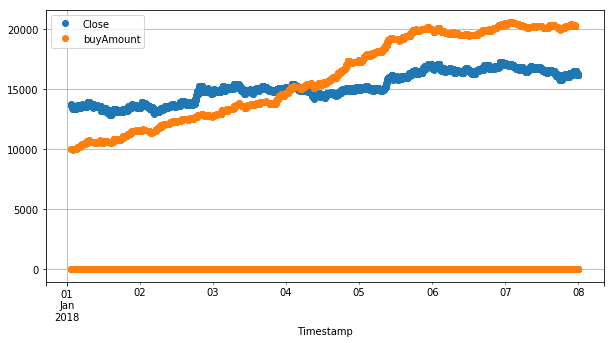

In [119]:
newdf.plot(x='Timestamp', y=['Close', 'buyAmount'], style='o',figsize=(10,5), grid=True)

In [120]:
# csv_fn=f'{PATH}/tmp/sub4.csv'
# sub.to_csv(csv_fn, index=False)
# FileLink(csv_fn)

## Random Forest

In [121]:
from sklearn.ensemble import RandomForestRegressor

In [122]:
((val,trn), (y_val,y_trn)) = split_by_idx(val_idx, df.values, y)

In [123]:
m = RandomForestRegressor(n_estimators=40, max_features=0.99, min_samples_leaf=2,
                          n_jobs=-1, oob_score=True)
m.fit(trn, y_trn);

In [124]:
def PredtoClass(a):
    pred_class = []
    for i in range(len(a)):
        if a[i]<.5:
            pred_class.append(0)
        else:
            pred_class.append(1)
    return pred_class
def accuracy(preds, y_val):
    return  sum(1- abs(PredtoClass(preds) - y_val))/len(y_val)

Accuracy on the validation set using a Random Forest Regressor

In [125]:
preds = m.predict(val)
m.score(trn, y_trn), m.score(val, y_val), m.oob_score_, accuracy(preds, y_val)

(0.9648108240032722, 0.7311986107383425, 0.8340389963621366, 0.9198)

In [126]:
preds_test = m.predict(df_test.values)

In [127]:
sub = pd.DataFrame({'Timestamp':test.index, 'action':PredtoClass(preds_test)})[['Timestamp', 'action']]
sub.head(10)

,Timestamp,action
0,2018-01-01 01:21:00,0
1,2018-01-01 01:22:00,0
2,2018-01-01 01:23:00,0
3,2018-01-01 01:24:00,1
4,2018-01-01 01:25:00,1
5,2018-01-01 01:26:00,1
6,2018-01-01 01:27:00,1
7,2018-01-01 01:28:00,1
8,2018-01-01 01:29:00,1
9,2018-01-01 01:30:00,1


In [128]:
# csv_fn=f'{PATH}/tmp/RFsub5.csv'
# sub.to_csv(csv_fn, index=False)
# FileLink(csv_fn)